In [1]:
from solid import *
from solid.utils import *
from math import sin, cos, radians, degrees, sqrt
# import ipywidgets as widgets

from intake import extrude_intake_manifold
import viewscad

In [2]:
#############Static Config#############
# CircleResolution = 100 #REMOVE FOR FREECAD COMPATABILITY 

 TODO: verify wallWidth addition to solids works
               (area is no less than intakeRadius throughout the model)
               only pressure loss should be from friction and filtering no venturi effect

 TODO: may make sense to define this as an object to access local variables etc.

### DESIGN GOAL:
- create an object that will possibly be used for:
- 1. design optimization for wetScrubber and/or vortex filterArray
- 2. grid array iteration (for instance: iterating for effective paricle diameter in
-  sequential-parallel array given a volume/manifold geometry)

In [4]:
def cycloneFilter(
        intakeSlitHeight,
        intakeSlitWidth,
        intakeLeft,
        vortexSearcherDepth,
        collectorDepth,
        cylinderRadius,
        cylinderHeight,
        wallWidth
):
    # TODO: assert pir^2 must be greater than intake cross section where r is cylinderRadius.
    # need more safety constraints.
    #TODO: verify intake and outlet radius
    '''
    Creates a Cone filter hull
    
    Parameters:
        intakeSlitHeight: air intake nozzle height
        intakeSlitWidth: air intake nozzle width, should be minimized to particle/blob diameter
        intakeLeft: if True, put intake on left side of filter, else place on right. 
        useful for symmetric arrays in rectangular manifolds.
        vortexSearcherDepth: sets depth of vortex (considered only past intakeSlitHeight)
        collectorDepth: depth of collector cone after cylinder
        cylinderRadius: radius of cylinder that makes up the hull
        cylinderHeight: height of cylinder that makes up the hull
        wallWidth: width of wall for all parts
    '''
    
    #define intake radius to ensure intake and outlet cross sectional area is equivalent
    #this optimizes for pressure drop across the filter 
    intakeRadius = sqrt(intakeSlitHeight*intakeSlitWidth/pi)
    assert cylinderRadius > intakeRadius
    intakeSlitLength = cylinderRadius//2

    ############# Build Solids: #############
    # build each part
    mainBodySolid = cylinder(r=(cylinderRadius + wallWidth), h=(cylinderHeight+wallWidth))
                            #  h=(cylinderHeight+wallWidth), segments=CircleResolution)
    collectorConeSolid = cylinder(
        r1=(cylinderRadius + wallWidth), r2=(intakeRadius + wallWidth), h=collectorDepth)
        # r1=(cylinderRadius + wallWidth), r2=(intakeRadius + wallWidth), h=collectorDepth, segments=CircleResolution)
    vortexTubeSolid = cylinder(
        r=(intakeRadius + wallWidth), h=(vortexSearcherDepth + intakeSlitHeight))
        # r=(intakeRadius + wallWidth), h=(vortexSearcherDepth + intakeSlitHeight), segments=CircleResolution)
    intakeSolid = extrude_intake_manifold(
        # TODO: constants have no place in parametric models
        intake_resolution=100,
        exhaust_slit=intakeSlitHeight + wallWidth,
        exhaust_width=intakeSlitWidth + wallWidth,
        exhaust_length=intakeSlitLength)

    ############# Open holes inside solids: #############
    mainBody = mainBodySolid - \
        cylinder(r=cylinderRadius, h=cylinderHeight)
        # cylinder(r=cylinderRadius, h=cylinderHeight, segments=CircleResolution)
    collectorCone = collectorConeSolid - \
        hole()(cylinder(r1=cylinderRadius,
                        r2=intakeRadius, h=collectorDepth))
                        # r2=intakeRadius, h=collectorDepth, segments=CircleResolution))
    vortexTube = vortexTubeSolid - \
        hole()(cylinder(r=(intakeRadius),
                        h=(vortexSearcherDepth + intakeSlitHeight)))
                        # h=(vortexSearcherDepth + intakeSlitHeight), segments=CircleResolution))
    intake = intakeSolid - hole()(extrude_intake_manifold(
        intake_resolution=100,
        exhaust_slit=intakeSlitHeight,
        exhaust_width=intakeSlitWidth,
        exhaust_length=intakeSlitLength))

    ############# Assemble filter: #############
    # mainBody
    # TODO: remove rotates where appropriate
    if(intakeLeft is True):
        filter = mainBody + \
            rotate([180, 0, 0])(collectorCone) + \
            up(cylinderHeight - (vortexSearcherDepth + intakeSlitHeight-wallWidth))(vortexTube) + \
            left(cylinderRadius - intakeSlitWidth)(up(cylinderHeight - intakeSlitHeight/2 - wallWidth)
                                                   (rotate([90, 90, 0])(intake)))
    else:
        filter = mainBody + \
            rotate([180, 0, 0])(collectorCone) + \
            up(cylinderHeight - (vortexSearcherDepth + intakeSlitHeight-wallWidth))(vortexTube) + \
            right(cylinderRadius - intakeSlitWidth)(up(cylinderHeight - intakeSlitHeight/2 - wallWidth)
                                                    (rotate([90, 90, 0])(intake)))
    
    filter = down(cylinderHeight)(filter)
    return filter

In [5]:
############# Build Filter: #############
solution = cycloneFilter(
    intakeSlitHeight=10, intakeSlitWidth=2, 
    intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
    cylinderRadius=10, cylinderHeight=15, wallWidth=0.5)


### Optimization Considerations:
- minimize: cylinderHeight constrained by intakeSlitLength
- minimize: vortexSearcherDepth constrained by cylinderHeight (only increased based on low pressure aerodynamics)
- minimize: intakeSlitWidth: by particle diameter
- minimize: cylinderRadius for volume, otherwise this would be maximized (design constraint)
- minimize: wallWidth wrt pressure and material compressive strength
- maximize: intakeSlitLength
- maximize: collectorDepth ideally to infinity if pressure is infinity (perfect vacuum)

#### TODO: consider a higher level, safer parameterization for these considerations:
-               remove: cylinderHeight, cylinderRadius by intakeArea, vortexSearcherDepth(after CFD analysis wrt pressure and intake model),
-                             |_need to be constrained by pressure models

### FUTURE DEVELOPMENT:
-   SET INTAKE MANIFOLD WITHIN CYLINDER TO BE MORE FABRICATABLE (no inner masting of cyclone body)
-   empirically test collector cone diameter, may want to make larger or change in general
-   set minimum and maximum values for parameters
-  (so they dont create unsustainable models e.g.: intakeSlit>cylinderHeight)
-  then run optimization algorithm on it wrt CFD (consider FreeCAD)
-  also constrain the parameters to reduce testing (discretize and limit parameter space)

In [8]:
############# Writeout Filter Model #############
scad_render_to_file(
    solution,
    "cycloneFilter.scad"
)

'c:/Users/wardj/Desktop/code/solidutils-master/cycloneFilter.scad'

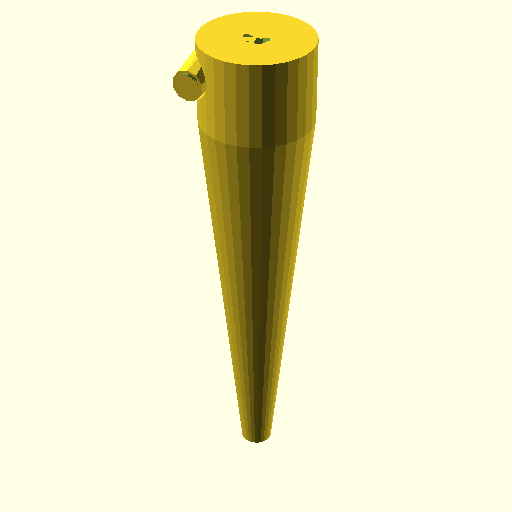

In [9]:
solution